In [ ]:
import os
from collections import namedtuple

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from sklearn import tree
import graphviz
import cv2
from cv2 import img_hash
import torch
from torch.utils import data

from sdcdup.utils import overlap_tag_pairs
from sdcdup.utils import overlap_tag_maps
from sdcdup.utils import generate_overlap_tag_slices
from sdcdup.utils import generate_tag_pair_lookup
from sdcdup.utils import get_project_root
from sdcdup.utils import fuzzy_compare
from sdcdup.utils import get_tile
from sdcdup.utils import get_hamming_distance
from sdcdup.utils import load_duplicate_truth
from sdcdup.utils import ImgMod
from sdcdup.utils import WrappedDataLoader
from sdcdup.utils import EvalDataset as Dataset

from sdcdup.features.image_features import load_image_overlap_properties
from sdcdup.models.dupnet import load_checkpoint

%load_ext dotenv
%dotenv
%matplotlib inline
%reload_ext autoreload
%autoreload 2

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 16
BIGGEST_SIZE = 20
plt.rc('font', size=BIGGEST_SIZE)         # controls default text sizes
plt.rc('axes', titlesize=BIGGEST_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=BIGGEST_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGEST_SIZE)  # fontsize of the figure title

project_root = get_project_root()
models_dir = os.path.join(project_root, 'models')
train_image_dir = os.path.join(project_root, os.getenv('RAW_DATA_DIR'), 'train_768')

overlap_tag_slices = generate_overlap_tag_slices()
img_overlap_index_maps = generate_tag_pair_lookup()

dtick = 256
n_ticks = 768 // dtick + 1
ticks = [i * dtick for i in range(n_ticks)]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# score_types = ['bmh', 'cmh', 'con', 'hom', 'eng', 'cor', 'epy', 'enp', 'pix', 'px0', 'shp']
n_matching_tiles_list = [9, 6, 4, 3, 2, 1]
overlap_image_maps = load_image_overlap_properties(n_matching_tiles_list)
print(len(overlap_image_maps))

In [ ]:
dup_truth = load_duplicate_truth()
print(len(dup_truth))

In [ ]:
def preprocess(x):
    return x.view(-1, 6, 256, 256).to(device)

## Evaluate all the ground truth examples on the model.

In [ ]:
TilePairs = namedtuple('TilePairs', 'img1_id img2_id img1_overlap_tag overlap_idx idx1 idx2')

ytrue = []
tile_pairs = []
for (img1_id, img2_id, img1_overlap_tag), is_dup in tqdm_notebook(dup_truth.items()):
    for overlap_idx, (idx1, idx2) in enumerate(img_overlap_index_maps[img1_overlap_tag]):
        tile_pairs.append(TilePairs(img1_id, img2_id, img1_overlap_tag, overlap_idx, idx1, idx2))
        ytrue.append(is_dup)
print(len(tile_pairs), sum(ytrue), len(ytrue))

In [ ]:
test_ds = Dataset(tile_pairs)
test_dl = data.DataLoader(test_ds, batch_size=256, num_workers=18)
test_dl = WrappedDataLoader(test_dl, preprocess)
print('Total number of batches to evaluate: ', len(test_dl))

In [ ]:
model = load_checkpoint(os.path.join(models_dir, 'dup_model.2019_0802_2209.best.pth'))
model.cuda()
model.to(device)

In [ ]:
model.eval()
with torch.no_grad():
    yprobs0 = [model(xb) for xb in tqdm_notebook(test_dl)]
    yprobs = np.vstack([l.cpu() for l in yprobs0]).reshape(-1)
    print(len(yprobs0), yprobs.shape, min(yprobs), max(yprobs))

In [ ]:
overlap_cnn_tile_scores = {}
for tp, yprob in zip(tile_pairs, yprobs):
    
    if (tp.img1_id, tp.img2_id) not in overlap_cnn_tile_scores:
        overlap_cnn_tile_scores[(tp.img1_id, tp.img2_id)] = {}
    
    if tp.img1_overlap_tag not in overlap_cnn_tile_scores[(tp.img1_id, tp.img2_id)]:
        n_overlapping_tiles = len(img_overlap_index_maps[tp.img1_overlap_tag])
        cnn_scores = np.zeros(n_overlapping_tiles)
        overlap_cnn_tile_scores[(tp.img1_id, tp.img2_id)][tp.img1_overlap_tag] = cnn_scores
    
    overlap_cnn_tile_scores[(tp.img1_id, tp.img2_id)][tp.img1_overlap_tag][tp.overlap_idx] = yprob

DNN_Stats = namedtuple('dnn_stats', ['yprob', 'ypred', 'ytrue', 'loss', 'yconf', 'pix'])

dup_dict = {}
for (img1_id, img2_id, img1_overlap_tag), ytrue in tqdm_notebook(dup_truth.items()):
    assert img1_id < img2_id

    if (img1_id, img2_id) not in overlap_image_maps:
        # TODO: explain why this conditional is here OR fix it to where it doesn't have to be.
#         print('1', ytrue, img1_id, img2_id, img1_overlap_tag)
        continue
    if img1_overlap_tag not in overlap_image_maps[(img1_id, img2_id)]:
        # TODO: explain why this conditional is here OR fix it to where it doesn't have to be.
#         print('2', ytrue, img1_id, img2_id, img1_overlap_tag)
        continue
    scores = overlap_image_maps[(img1_id, img2_id)][img1_overlap_tag]
    if len(scores.pix) < 2:
        print('3')
#         continue
    pix = max(scores.pix)
    if (img1_id, img2_id) not in overlap_cnn_tile_scores:
        print('4')
#         continue
    if img1_overlap_tag not in overlap_cnn_tile_scores[(img1_id, img2_id)]:
        print('5')
#         continue

    dcnn_scores_raw = overlap_cnn_tile_scores[(img1_id, img2_id)][img1_overlap_tag]
    dcnn_conf_raw = np.abs((dcnn_scores_raw - 0.5) * 2) # confidence? (1: very, 0: not at all)
    yconf = np.min(dcnn_conf_raw)
    yprob = np.min(dcnn_scores_raw)
    ypred = (yprob > 0.5) * 1
    assert ypred <= 1
    
    if ytrue:
        bce = - ytrue * np.log(yprob)
    else:
        bce = - (1 - ytrue) * np.log(1 - yprob)
    
    dup_dict[(img1_id, img2_id, img1_overlap_tag)] = DNN_Stats(yprob, ypred, ytrue, bce, yconf, pix)

## Try out a decision tree classifier for dup_truth

In [ ]:
missing_maps = 0
missing_tags = 0
L = []
X = []
Y = []
for (img1_id, img2_id, img1_overlap_tag), is_dup in dup_truth.items():
    
    if (img1_id, img2_id) not in overlap_image_maps:
        missing_maps += 1
        continue
    overlap_maps = overlap_image_maps[(img1_id, img2_id)]
    if img1_overlap_tag not in overlap_maps:
        missing_tags += 1
        continue
    scores = overlap_maps[img1_overlap_tag]
    if len(scores.pix) < 2:
        continue
    
    L.append((img1_id, img2_id, img1_overlap_tag))
    X.append([
        dup_dict[(img1_id, img2_id, img1_overlap_tag)].ypred,
        dup_dict[(img1_id, img2_id, img1_overlap_tag)].loss,
#         min(scores.bmh),
#         min(scores.cmh),
#         max(scores.pix), 
#         min(scores.pyr),
#         max(scores.enp),
    ])
    Y.append([is_dup])

L = np.array(L)
X = np.array(X)
Y = np.array(Y)
# X = [[0, 0], [1, 1]]
# Y = [0, 1]

print('missing maps: ', missing_maps)
print('missing tags: ', missing_tags)
print(len(X))
print(len(Y), sum(Y))

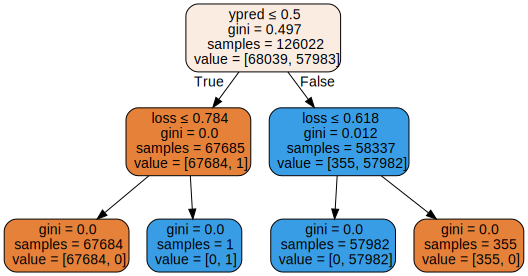

In [19]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, Y)
dot_data = tree.export_graphviz(
    clf, 
    out_file=None, 
    feature_names=[
        'ypred',
        'loss',
#         'min(bmh)', 
#         'min(cmh)', 
#         'max(pix)', 
#         'min(pyr)', 
#         'max(enp)',
    ], 
    filled=True, 
    rounded=True, 
    special_characters=True, 
    leaves_parallel=True) 

graph = graphviz.Source(dot_data) 
graph

## decision tree analysis (Optional)

In [ ]:
all_nodes = clf.apply(X)

nodes = np.where(all_nodes == 3)
np.argmin(X[nodes]), np.min(X[nodes]), np.argmax(X[nodes]), np.max(X[nodes])

In [ ]:
idx = 0
print(L[nodes][idx], Y[nodes][idx], X[nodes][idx])
print(overlap_image_maps[(L[nodes][idx][0], L[nodes][idx][1])])

In [ ]:
tricky_examples_9 = [
    ['e28669903.jpg', 'ed2998ef7.jpg', '08', 1],
    ['66482462b.jpg', 'e2497099c.jpg', '08', 1],
    ['73fec0637.jpg', '8b0219c19.jpg', '08', 0],
]

tricky_examples_6 = [
    ['00ce2c1c0.jpg', '68ef625ba.jpg', '18', 1],
    ['01178499a.jpg', '7a7a0034a.jpg', '05', 1],
    ['1ebdf2f08.jpg', 'b1bfb768c.jpg', '05', 1],  # [91.          0.99781223]
    ['d4f0aaa70.jpg', 'd84d4a78a.jpg', '05', 0],  # [5.95230000e+04 9.98578088e-01] 
    ['012d8cca1.jpg', 'bc45cee87.jpg', '07', 1],
    ['2323bf875.jpg', 'b5da61fce.jpg', '07', 1],  # [2.05663500e+06 9.98277186e-01]
    ['7f2be2b0a.jpg', '84dcdc7af.jpg', '07', 0],
    ['089858a56.jpg', '903a8b121.jpg', '38', 1],
    ['468bf9178.jpg', '6090b3a8b.jpg', '38', 1],  # [1.30900000e+03 9.97640283e-01]
    ['d843fc5ca.jpg', 'e805070df.jpg', '38', 1],
    ['000194a2d.jpg', '384765ab2.jpg', '38', 1],
    ['0ef6cd331.jpg', 'e6a6f80cd.jpg', '38', 0],  # [1.72270000e+04 9.98394555e-01]
]

tricky_examples_4 = [
    ['0a33ce967.jpg', '3964f0cee.jpg', '04', 1],
    ['d164aea52.jpg', 'fded6e12d.jpg', '04', 1],
    ['c3193fb05.jpg', 'cc68e7818.jpg', '15', 0],  # [2.16300000e+04 9.98311792e-01]
    ['331987f64.jpg', '4869b48b6.jpg', '15', 0],
    ['0318fc519.jpg', 'b7feb225a.jpg', '37', 1],
    ['7234a3a53.jpg', 'dc6534704.jpg', '37', 1],
    ['de6fb187d.jpg', 'ea6dc23b7.jpg', '37', 1],  # [223.           0.99544613]
    ['cd3c59923.jpg', 'efdd03319.jpg', '37', 0],  # [6.70246000e+05 9.99894307e-01] 
    ['0c279107f.jpg', '3b1314d5d.jpg', '37', 0],
    ['42f02a4a4.jpg', '7d31648ff.jpg', '58', 0],  # '48' ???
]

tricky_examples_3 = [
    ['204906e27.jpg', '892a69b4b.jpg', '02', 1],  # [6.31644000e+05 9.97614902e-01]
    ['813c8ec35.jpg', 'caa94ffc3.jpg', '06', 0],  # [1.76759000e+05 9.99834742e-01]
    ['0256ef90d.jpg', '46da51931.jpg', '06', 0],  # [3.70260000e+05 9.99319673e-01]
    ['0ee790381.jpg', 'ac87bcee5.jpg', '06', 0],
    ['2f6c0deaa.jpg', 'e44a4f5b0.jpg', '28', 1],  # [24.          0.99509307]
    ['0ef6cd331.jpg', '813c8ec35.jpg', '28', 0],  # [1.79442000e+05 9.98195859e-01]
    ['4c56d2f00.jpg', 'dcd94e973.jpg', '68', 1],  # [6.31635000e+05 9.97534103e-01]
    ['b645cd49b.jpg', 'f2e554691.jpg', '68', 1],  # [3.76847000e+05 9.96659721e-01]
    ['b998c7415.jpg', 'd4d26f700.jpg', '68', 1],  # [3.76847000e+05 9.96680501e-01]
    ['0ef6cd331.jpg', '3a9e579aa.jpg', '68', 0],  # [1.62810000e+04 9.98394555e-01]
    ['a61b3e245.jpg', 'd84d4a78a.jpg', '68', 0],  # [2.59134100e+06 9.99175738e-01]
    ['2095da0cb.jpg', '45b1a4561.jpg', '68', 0],
]


In [ ]:
def plot_image_pair(img1_id, img2_id, img1_overlap_tag, is_dup):
    
    imgmod1 = ImgMod(os.path.join(train_image_dir, img1_id))
    imgmod2 = ImgMod(os.path.join(train_image_dir, img2_id))
    dcnn_scores_raw = overlap_cnn_tile_scores[(img1_id, img2_id)][img1_overlap_tag]
    print(dcnn_scores_raw)
    print(is_dup, overlap_image_maps[(img1_id, img2_id)])
    
    dtick = 256
    n_ticks = imgmod1.shape[1] // dtick + 1
    ticks = [i * dtick for i in range(n_ticks)]

    slice1 = overlap_tag_slices[img1_overlap_tag]
    slice2 = overlap_tag_slices[overlap_tag_pairs[img1_overlap_tag]]

    cmh2 = img_hash.colorMomentHash(imgmod1.parent_rgb[slice1])
    cmh1 = img_hash.colorMomentHash(imgmod2.parent_rgb[slice2])
    score0_norm = np.linalg.norm(cmh1 - cmh2)
    score0_expnorm = np.exp(-score0_norm)
    print(len(imgmod1.parent_rgb[slice1]), len(cmh1[0]))
#     print(cmh1.reshape((6, 7)))
#     print(cmh2.reshape((6, 7)))
    print(score0_expnorm, score0_norm)
    
    m12 = np.median(np.vstack([imgmod1.parent_rgb[slice1], imgmod2.parent_rgb[slice2]]), axis=(0, 1), keepdims=True).astype(np.uint8)
    
    brightness_level = -100 if np.sum(m12) >= 384 else 100
    img1 = imgmod1.brightness_shift('L', brightness_level)
    img2 = imgmod2.brightness_shift('L', brightness_level)
    
    img1_drop = imgmod1.parent_rgb - m12
    img2_drop = imgmod2.parent_rgb - m12
    
    img1[slice1] = img1_drop[slice1]
    img2[slice2] = img2_drop[slice2]

    img1_overlap_map = overlap_tag_maps[img1_overlap_tag]
    img2_overlap_map = overlap_tag_maps[overlap_tag_pairs[img1_overlap_tag]]

    for idx1, idx2 in zip(img1_overlap_map, img2_overlap_map):
        
        print(f'tile {idx1} / tile {idx2}')
        tile1 = get_tile(imgmod1.parent_rgb, idx1)
        tile2 = get_tile(imgmod2.parent_rgb, idx2)
        score0 = fuzzy_compare(tile1, tile2)
        
        bmh1_0 = img_hash.blockMeanHash(tile1)
        bmh2_0 = img_hash.blockMeanHash(tile2)
        score0_hamm = get_hamming_distance(bmh1_0, bmh2_0, normalize=True, as_score=True)
#         print(bmh1_0)
#         print(bmh2_0)

        cmh1_0 = img_hash.colorMomentHash(tile1)
        cmh2_0 = img_hash.colorMomentHash(tile2)
        score0_norm = np.linalg.norm(cmh1_0 - cmh2_0)
        score0_expnorm = np.exp(-score0_norm)
#         print(cmh1_0.reshape((6, 7)))
#         print(cmh2_0.reshape((6, 7)))
        
        tile1_drop = get_tile(img1_drop, idx1)
        tile2_drop = get_tile(img2_drop, idx2)
        score1 = fuzzy_compare(tile1_drop, tile2_drop)

        bmh1_1 = img_hash.blockMeanHash(tile1_drop)
        bmh2_1 = img_hash.blockMeanHash(tile2_drop)
        score1_hamm = get_hamming_distance(bmh1_1, bmh2_1, normalize=True, as_score=True)
#         print(bmh1_1)
#         print(bmh2_1)
        
        cmh1_1 = img_hash.colorMomentHash(tile1_drop)
        cmh2_1 = img_hash.colorMomentHash(tile2_drop)
        score1_norm = np.linalg.norm(cmh1_1 - cmh2_1)
        score1_expnorm = np.exp(-score1_norm)
#         print(cmh1_1.reshape((6, 7)))
#         print(cmh2_1.reshape((6, 7)))
        
        m12_tile = np.median(np.vstack([tile1, tile2]), axis=(0, 1), keepdims=True).astype(np.uint8)
        tile1_drop = tile1 - m12_tile
        tile2_drop = tile2 - m12_tile
        score2 = fuzzy_compare(tile1_drop, tile2_drop)
        
        bmh1_2 = img_hash.blockMeanHash(tile1_drop)
        bmh2_2 = img_hash.blockMeanHash(tile2_drop)
        score2_hamm = get_hamming_distance(bmh1_2, bmh2_2, normalize=True, as_score=True)
#         print(bmh1_2)
#         print(bmh2_2)
        
        cmh1_2 = img_hash.colorMomentHash(tile1_drop)
        cmh2_2 = img_hash.colorMomentHash(tile2_drop)
        score2_norm = np.linalg.norm(cmh1_2 - cmh2_2)
        score2_expnorm = np.exp(-score2_norm)
#         print(cmh1_2.reshape((6, 7)))
#         print(cmh2_2.reshape((6, 7)))
        
        print(f'{score0:10.8f}, {score0_hamm:10.8f}, {score0_norm:10.8f}, {score0_expnorm:10.8f}')
        print(f'{score1:10.8f}, {score1_hamm:10.8f}, {score1_norm:10.8f}, {score1_expnorm:10.8f}', m12)
        print(f'{score2:10.8f}, {score2_hamm:10.8f}, {score2_norm:10.8f}, {score2_expnorm:10.8f}', m12_tile)
        
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
    
    ax1.imshow(img1)
    ax1.set_title(f'{img1_id}')
    ax1.set_xticks(ticks)
    ax1.set_yticks(ticks)
    
    ax2.imshow(img2)
    ax2.set_title(f'{img2_id}')
    ax2.set_xticks(ticks)
    ax2.set_yticks(ticks)

In [ ]:
plot_image_pair(*tricky_examples_6[0])